In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [3]:
seq_train = pd.read_parquet("../../pipeline/output/train_data/train_filtered.parquet")
seq_test = pd.read_parquet("../../pipeline/output/test_data/test_filtered.parquet")


In [4]:
seq_test['pdb_id'].unique().shape

(500,)

# Clusters

In [5]:
clusters = pd.read_csv("../../pipeline/output/mmseqs/all_seqs_clust.tsv", sep="\t", header=None)
similarity = pd.read_csv("../../pipeline/output/mmseqs/all_seqs_similarity.tsv", sep="\t", header=None)
clusters.columns = ["cluster_id", "seq_id"]
similarity.columns = ['queryID',"targetID", "alnScore", "seqIdentity", "eVal", "qStart", "qEnd", "qLen", "tStart", "tEnd", "tLen",]
display(clusters.head())
display(similarity.head())

,cluster_id,seq_id
0,train_5ZZK_A,train_5ZZK_A
1,train_6BZQ_C,train_6BZQ_C
2,train_6BZQ_C,train_6BZQ_D
3,train_6BZQ_C,train_6BZA_A
4,train_6BZQ_C,train_6BZA_B


,queryID,targetID,alnScore,seqIdentity,eVal,qStart,qEnd,qLen,tStart,tEnd,tLen
0,train_3ZKP_A,train_3ZKP_A,799,1.000,1.508000e-262,0,390,391,0,390,391
1,train_3ZKP_A,train_5L92_B,228,0.388,3.698000e-65,12,353,391,9,338,370
2,train_3ZKP_A,train_5L94_B,224,0.384,6.042000e-64,12,353,391,5,328,360
3,train_3ZKP_A,train_5L94_A,223,0.382,1.533000e-63,12,353,391,11,353,385
4,train_3ZKP_A,train_5L92_A,223,0.382,1.533000e-63,12,353,391,12,354,386


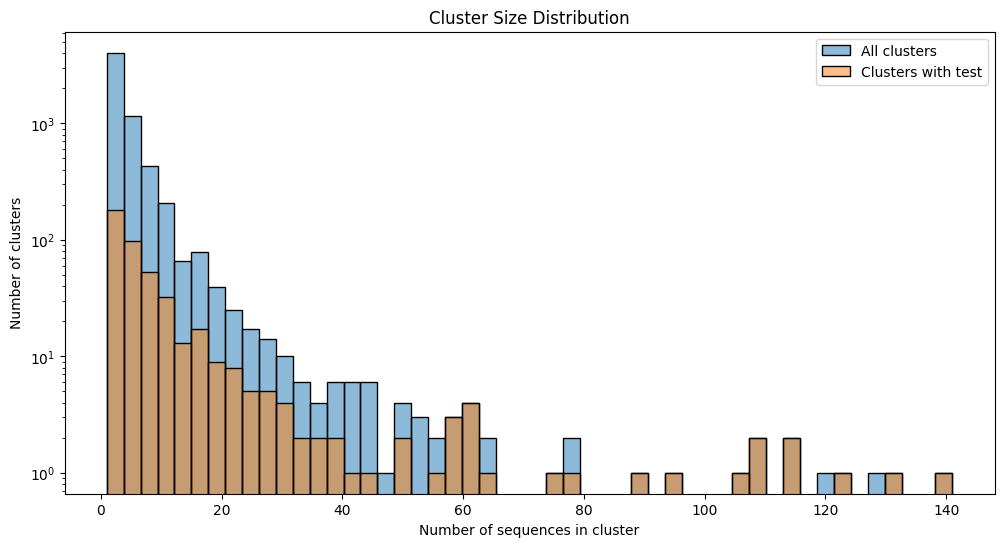

Total clusters: 6141
Clusters with test sequences: 457
Percentage of clusters with test: 7.44%


In [6]:
clusters[['split', 'pdb_id', 'chain']] = clusters['seq_id'].str.split('_', expand=True)
clusters[['cluster_split', 'cluster_pdb', 'cluster_chain']] = clusters['cluster_id'].str.split('_', expand=True)

cluster_sizes = clusters['cluster_id'].value_counts().reset_index()
cluster_sizes.columns = ['cluster_id', 'size']

clusters_with_test = clusters[clusters['split'] == 'test']['cluster_id'].unique()
test_clusters_df = clusters[clusters['cluster_id'].isin(clusters_with_test)]
test_cluster_sizes = test_clusters_df['cluster_id'].value_counts().reset_index()
test_cluster_sizes.columns = ['cluster_id', 'size']

plt.figure(figsize=(12, 6))
sns.histplot(data=cluster_sizes, x='size', bins=50, alpha=0.5, label='All clusters')
sns.histplot(data=test_cluster_sizes, x='size', bins=50, alpha=0.5, label='Clusters with test')
plt.title('Cluster Size Distribution')
plt.xlabel('Number of sequences in cluster')
plt.ylabel('Number of clusters')
plt.yscale('log')
plt.legend()
plt.show()

print(f"Total clusters: {len(cluster_sizes)}")
print(f"Clusters with test sequences: {len(test_cluster_sizes)}")
print(f"Percentage of clusters with test: {len(test_cluster_sizes)/len(cluster_sizes)*100:.2f}%")


PDBs with chains in multiple clusters: 36

Top 10 PDBs by number of different clusters:
pdb_id
6OYC    3
1LPG    2
1XVL    2
1LPZ    2
2P4E    2
2PRG    2
3ENB    2
2Y1R    2
3LDZ    2
3LNN    2
Name: cluster_id, dtype: int64


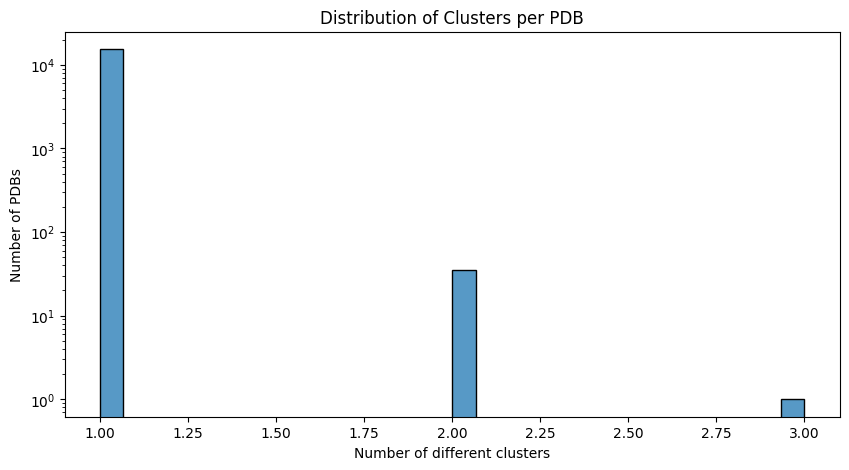


Example of PDB with most clusters:
             seq_id    cluster_id  split
20051  train_1LPG_A  train_1LPZ_A  train
11595  train_1LPG_B  train_3QK1_A  train


In [7]:
pdb_clusters = clusters.groupby('pdb_id')['cluster_id'].nunique()
split_pdbs = clusters.groupby(['pdb_id', 'split']).size().unstack(fill_value=0)

multi_cluster_pdbs = pdb_clusters[pdb_clusters > 1]
print(f"PDBs with chains in multiple clusters: {len(multi_cluster_pdbs)}")
print("\nTop 10 PDBs by number of different clusters:")
print(multi_cluster_pdbs.sort_values(ascending=False).head(10))

plt.figure(figsize=(10, 5))
sns.histplot(data=pdb_clusters, bins=30)
plt.title('Distribution of Clusters per PDB')
plt.xlabel('Number of different clusters')
plt.ylabel('Number of PDBs')
plt.yscale('log')
plt.show()

print("\nExample of PDB with most clusters:")
example_pdb = multi_cluster_pdbs.index[0]
print(clusters[clusters['pdb_id'] == example_pdb][['seq_id', 'cluster_id', 'split']].sort_values('cluster_id'))


In [8]:
seq_train[seq_train.id.isin(['train_1LPG_A', 'train_1LPG_B'])]

,id,pdb_id,chain_id,length,sequence,residue_indices,b_factors,mean_b_factor,coords_ca
808,train_1LPG_A,1LPG,A,53,RKLCSLDNGDCDQFCHEEQNSVVCSCARGYTLADNGKACIPTGPYP...,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[66.42, 58.94, 40.66, 27.55, 30.97, 26.31, 23....",30.896226,"[41.50299835205078, -4.796999931335449, 37.361..."
809,train_1LPG_B,1LPG,B,234,IVGGQECKDGECPWQALLINEENEGFCGGTILSEFYILTAAHCLYQ...,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","[16.86, 17.91, 19.05, 24.14, 28.85, 24.14, 17....",23.786709,"[10.597999572753906, 14.116000175476074, 32.09..."


In [9]:
similarity.columns = ['query_id', 'target_id', 'score', 'identity', 'evalue', 'q_start', 'q_end', 'q_len', 't_start', 't_end', 't_len']

print("Similarity data shape:", similarity.shape)
print("Similarity columns:", similarity.columns.tolist())
print("\nSample similarity data:")
display(similarity.head())

print(f"\nIdentity range: {similarity['identity'].min():.3f} - {similarity['identity'].max():.3f}")
print(f"Mean identity: {similarity['identity'].mean():.3f}")
print(f"Median identity: {similarity['identity'].median():.3f}")


Similarity data shape: (414949, 11)
Similarity columns: ['query_id', 'target_id', 'score', 'identity', 'evalue', 'q_start', 'q_end', 'q_len', 't_start', 't_end', 't_len']

Sample similarity data:


,query_id,target_id,score,identity,evalue,q_start,q_end,q_len,t_start,t_end,t_len
0,train_3ZKP_A,train_3ZKP_A,799,1.000,1.508000e-262,0,390,391,0,390,391
1,train_3ZKP_A,train_5L92_B,228,0.388,3.698000e-65,12,353,391,9,338,370
2,train_3ZKP_A,train_5L94_B,224,0.384,6.042000e-64,12,353,391,5,328,360
3,train_3ZKP_A,train_5L94_A,223,0.382,1.533000e-63,12,353,391,11,353,385
4,train_3ZKP_A,train_5L92_A,223,0.382,1.533000e-63,12,353,391,12,354,386



Identity range: 0.300 - 1.000
Mean identity: 0.718
Median identity: 0.871


In [10]:
def extract_pdb_from_id(seq_id):
    """Extract PDB ID from sequence ID (format: split_pdb_chain)"""
    parts = seq_id.split('_')
    if len(parts) >= 2:
        return parts[1]  # pdb_id is the second part
    return None

def calculate_max_identity_in_cluster(test_seq_id, cluster_data, similarity_data):
    """Calculate max identity for a test sequence within its cluster, excluding same PDB"""
    
    # Get the cluster for this test sequence
    cluster_id = cluster_data[cluster_data['seq_id'] == test_seq_id]['cluster_id'].iloc[0]
    
    # Get all sequences in the same cluster
    cluster_sequences = cluster_data[cluster_data['cluster_id'] == cluster_id]['seq_id'].tolist()
    
    # Extract PDB ID for the test sequence
    test_pdb = extract_pdb_from_id(test_seq_id)
    
    # Filter similarities where query is our test sequence
    query_similarities = similarity_data[similarity_data['query_id'] == test_seq_id].copy()
    
    # Filter to only targets that are in the same cluster
    cluster_similarities = query_similarities[query_similarities['target_id'].isin(cluster_sequences)].copy()
    
    # Extract PDB IDs for targets
    cluster_similarities['target_pdb'] = cluster_similarities['target_id'].apply(extract_pdb_from_id)
    
    # Exclude comparisons with same PDB structure
    different_pdb_similarities = cluster_similarities[cluster_similarities['target_pdb'] != test_pdb]
    
    # Find maximum identity
    if len(different_pdb_similarities) > 0:
        max_identity = different_pdb_similarities['identity'].max()
        max_target = different_pdb_similarities.loc[different_pdb_similarities['identity'].idxmax(), 'target_id']
        return max_identity, max_target, len(different_pdb_similarities)
    else:
        return None, None, 0

# Get test sequences
test_sequences = clusters[clusters['split'] == 'test']['seq_id'].unique()
print(f"Analyzing {len(test_sequences)} test sequences...")

# Calculate max identities for all test sequences
max_identities = []
analysis_results = []

for test_seq in test_sequences:
    max_id, max_target, num_comparisons = calculate_max_identity_in_cluster(test_seq, clusters, similarity)
    
    if max_id is not None:
        max_identities.append(max_id)
        analysis_results.append({
            'test_seq': test_seq,
            'max_identity': max_id,
            'max_target': max_target,
            'num_comparisons': num_comparisons
        })

print(f"Successfully analyzed {len(max_identities)} test sequences with cluster similarities")


Analyzing 867 test sequences...
Successfully analyzed 645 test sequences with cluster similarities


Max Identity Statistics for Test Sequences:
Number of test sequences analyzed: 645
Min max identity: 0.304
Max max identity: 1.000
Mean max identity: 0.820
Median max identity: 0.939
Std max identity: 0.220

Identity Distribution:
High identity (≥90%): 409 sequences (63.4%)
Medium identity (50-90%): 131 sequences (20.3%)
Low identity (<50%): 105 sequences (16.3%)


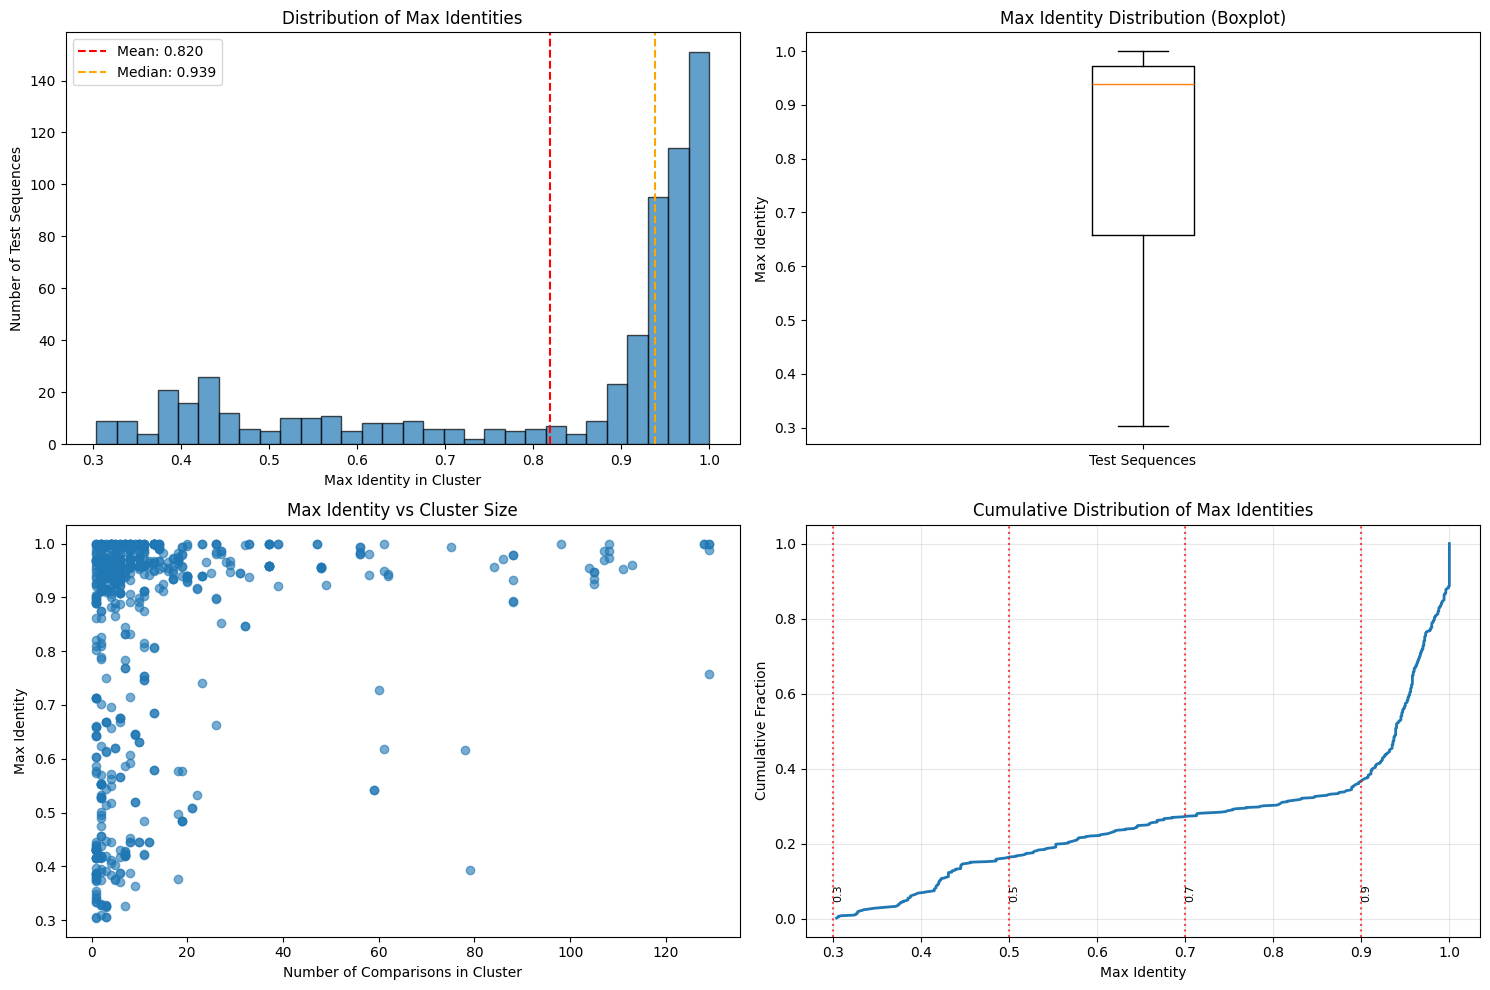


Examples of test sequences with different identity levels:
------------------------------------------------------------
High identity examples (≥90%):
  test_6Z1C_A -> train_1F0Q_A: 0.923
  test_3TTJ_A -> train_3TTI_A: 0.944
  test_7BDQ_A -> train_2GTN_A: 0.971

Low identity examples (<50%):
  test_3RO1_A -> train_5Z5A_B: 0.371
  test_1I9T_A -> train_4NYH_C: 0.327
  test_3WCK_C -> train_7CAO_A: 0.446


In [11]:
if len(max_identities) > 0:
    results_df = pd.DataFrame(analysis_results)
    
    print("Max Identity Statistics for Test Sequences:")
    print("=" * 50)
    print(f"Number of test sequences analyzed: {len(max_identities)}")
    print(f"Min max identity: {min(max_identities):.3f}")
    print(f"Max max identity: {max(max_identities):.3f}")
    print(f"Mean max identity: {np.mean(max_identities):.3f}")
    print(f"Median max identity: {np.median(max_identities):.3f}")
    print(f"Std max identity: {np.std(max_identities):.3f}")
    
    # Identity ranges
    high_identity = [x for x in max_identities if x >= 0.9]
    medium_identity = [x for x in max_identities if 0.5 <= x < 0.9]
    low_identity = [x for x in max_identities if x < 0.5]
    
    print(f"\nIdentity Distribution:")
    print(f"High identity (≥90%): {len(high_identity)} sequences ({len(high_identity)/len(max_identities)*100:.1f}%)")
    print(f"Medium identity (50-90%): {len(medium_identity)} sequences ({len(medium_identity)/len(max_identities)*100:.1f}%)")
    print(f"Low identity (<50%): {len(low_identity)} sequences ({len(low_identity)/len(max_identities)*100:.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram of max identities
    axes[0, 0].hist(max_identities, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Max Identity in Cluster')
    axes[0, 0].set_ylabel('Number of Test Sequences')
    axes[0, 0].set_title('Distribution of Max Identities')
    axes[0, 0].axvline(np.mean(max_identities), color='red', linestyle='--', label=f'Mean: {np.mean(max_identities):.3f}')
    axes[0, 0].axvline(np.median(max_identities), color='orange', linestyle='--', label=f'Median: {np.median(max_identities):.3f}')
    axes[0, 0].legend()
    
    # Box plot
    axes[0, 1].boxplot(max_identities)
    axes[0, 1].set_ylabel('Max Identity')
    axes[0, 1].set_title('Max Identity Distribution (Boxplot)')
    axes[0, 1].set_xticklabels(['Test Sequences'])
    
    # Number of comparisons vs max identity
    axes[1, 0].scatter(results_df['num_comparisons'], results_df['max_identity'], alpha=0.6)
    axes[1, 0].set_xlabel('Number of Comparisons in Cluster')
    axes[1, 0].set_ylabel('Max Identity')
    axes[1, 0].set_title('Max Identity vs Cluster Size')
    
    # Cumulative distribution
    sorted_identities = sorted(max_identities)
    cumulative = np.arange(1, len(sorted_identities) + 1) / len(sorted_identities)
    axes[1, 1].plot(sorted_identities, cumulative, linewidth=2)
    axes[1, 1].set_xlabel('Max Identity')
    axes[1, 1].set_ylabel('Cumulative Fraction')
    axes[1, 1].set_title('Cumulative Distribution of Max Identities')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add threshold lines
    for threshold in [0.3, 0.5, 0.7, 0.9]:
        axes[1, 1].axvline(threshold, color='red', linestyle=':', alpha=0.7)
        axes[1, 1].text(threshold, 0.05, f'{threshold}', rotation=90, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Show some examples
    print(f"\nExamples of test sequences with different identity levels:")
    print("-" * 60)
    
    # High identity examples
    if len(high_identity) > 0:
        high_examples = results_df[results_df['max_identity'] >= 0.9].head(3)
        print("High identity examples (≥90%):")
        for _, row in high_examples.iterrows():
            print(f"  {row['test_seq']} -> {row['max_target']}: {row['max_identity']:.3f}")
    
    # Low identity examples  
    if len(low_identity) > 0:
        low_examples = results_df[results_df['max_identity'] < 0.5].head(3)
        print("\nLow identity examples (<50%):")
        for _, row in low_examples.iterrows():
            print(f"  {row['test_seq']} -> {row['max_target']}: {row['max_identity']:.3f}")

else:
    print("No test sequences with cluster similarities found!")


In [12]:
# Validation set selection based on cluster size distribution matching
print("Creating validation set with cluster distribution matching test set...")
print("=" * 70)

# First, let's analyze the current cluster size distribution for test sequences
# Get information about clusters with test sequences (from cell 5)
test_cluster_info = test_cluster_sizes.copy()
test_cluster_sizes_values = test_cluster_info['size'].values

# Define bins for cluster sizes (same as used in previous visualization)
cluster_size_bins = [1, 2, 5, 10, 20, 50, 100, float('inf')]
bin_labels = ['1', '2-4', '5-9', '10-19', '20-49', '50-99', '100+']

# Calculate test distribution
test_cluster_bins = pd.cut(test_cluster_sizes_values, bins=cluster_size_bins, labels=bin_labels, include_lowest=True)
test_distribution = test_cluster_bins.value_counts().sort_index()
test_distribution_pct = (test_distribution / test_distribution.sum() * 100).round(1)

print("Test set cluster size distribution:")
for bin_label, count, pct in zip(test_distribution.index, test_distribution.values, test_distribution_pct.values):
    print(f"  {bin_label}: {count} clusters ({pct}%)")

total_test_clusters = len(test_cluster_info)
print(f"\nTotal test clusters: {total_test_clusters}")

# Get clusters that don't contain any test sequences
all_cluster_ids = set(clusters['cluster_id'].unique())
test_cluster_ids = set(test_cluster_info['cluster_id'].unique())
available_cluster_ids = all_cluster_ids - test_cluster_ids

print(f"Available clusters for validation: {len(available_cluster_ids)}")

# Get information about available clusters
available_clusters_info = clusters[clusters['cluster_id'].isin(available_cluster_ids)].groupby('cluster_id').agg({
    'seq_id': 'count',
    'split': lambda x: list(x.unique())
}).rename(columns={'seq_id': 'cluster_size'}).reset_index()

# Filter to only clusters that contain train sequences
available_clusters_info = available_clusters_info[
    available_clusters_info['split'].apply(lambda x: 'train' in x)
].copy()

print(f"Available clusters with train sequences: {len(available_clusters_info)}")

# Categorize available clusters by size
available_clusters_info['size_bin'] = pd.cut(
    available_clusters_info['cluster_size'], 
    bins=cluster_size_bins, 
    labels=bin_labels, 
    include_lowest=True
)

available_distribution = available_clusters_info['size_bin'].value_counts().sort_index()
print(f"\nAvailable clusters distribution:")
for bin_label, count in zip(available_distribution.index, available_distribution.values):
    print(f"  {bin_label}: {count} clusters")


Creating validation set with cluster distribution matching test set...
Test set cluster size distribution:
  1: 149 clusters (32.6%)
  2-4: 98 clusters (21.4%)
  5-9: 99 clusters (21.7%)
  10-19: 58 clusters (12.7%)
  20-49: 32 clusters (7.0%)
  50-99: 13 clusters (2.8%)
  100+: 8 clusters (1.8%)

Total test clusters: 457
Available clusters for validation: 5684
Available clusters with train sequences: 5684

Available clusters distribution:
  1: 3380 clusters
  2-4: 1273 clusters
  5-9: 718 clusters
  10-19: 238 clusters
  20-49: 67 clusters
  50-99: 6 clusters
  100+: 2 clusters


In [13]:
# Now select validation clusters to match test distribution
print(f"\nSelecting validation clusters to match test distribution...")
print("-" * 60)

# Calculate how many clusters we need for each bin
target_validation_clusters = []
selected_clusters = {}

for bin_label in bin_labels:
    test_count = test_distribution.get(bin_label, 0)
    available_count = available_distribution.get(bin_label, 0)
    
    print(f"Bin {bin_label}:")
    print(f"  Test clusters: {test_count}")
    print(f"  Available clusters: {available_count}")
    
    if test_count > 0 and available_count >= test_count:
        # We can select the same number as test
        target_count = test_count
        # Randomly select clusters from this bin
        bin_clusters = available_clusters_info[available_clusters_info['size_bin'] == bin_label]['cluster_id'].tolist()
        selected_bin_clusters = np.random.choice(bin_clusters, target_count, replace=False).tolist()
        selected_clusters[bin_label] = selected_bin_clusters
        print(f"  Selected: {target_count} clusters")
    elif test_count > 0 and available_count < test_count:
        # Not enough available - take all we have
        target_count = available_count
        bin_clusters = available_clusters_info[available_clusters_info['size_bin'] == bin_label]['cluster_id'].tolist()
        selected_clusters[bin_label] = bin_clusters
        print(f"  Selected: {target_count} clusters (all available - not enough for exact match)")
    else:
        selected_clusters[bin_label] = []
        print(f"  Selected: 0 clusters")

# Collect all selected validation clusters
validation_cluster_ids = []
for bin_clusters in selected_clusters.values():
    validation_cluster_ids.extend(bin_clusters)

print(f"\nTotal validation clusters selected: {len(validation_cluster_ids)}")

# Verify the distribution
validation_clusters_info = available_clusters_info[
    available_clusters_info['cluster_id'].isin(validation_cluster_ids)
].copy()

validation_distribution = validation_clusters_info['size_bin'].value_counts().sort_index()
validation_distribution_pct = (validation_distribution / validation_distribution.sum() * 100).round(1)

print(f"\nDistribution comparison:")
print("-" * 40)
for bin_label in bin_labels:
    test_pct = test_distribution_pct.get(bin_label, 0)
    val_pct = validation_distribution_pct.get(bin_label, 0)
    print(f"{bin_label:>8}: Test {test_pct:>5.1f}% | Validation {val_pct:>5.1f}%")



Selecting validation clusters to match test distribution...
------------------------------------------------------------
Bin 1:
  Test clusters: 149
  Available clusters: 3380
  Selected: 149 clusters
Bin 2-4:
  Test clusters: 98
  Available clusters: 1273
  Selected: 98 clusters
Bin 5-9:
  Test clusters: 99
  Available clusters: 718
  Selected: 99 clusters
Bin 10-19:
  Test clusters: 58
  Available clusters: 238
  Selected: 58 clusters
Bin 20-49:
  Test clusters: 32
  Available clusters: 67
  Selected: 32 clusters
Bin 50-99:
  Test clusters: 13
  Available clusters: 6
  Selected: 6 clusters (all available - not enough for exact match)
Bin 100+:
  Test clusters: 8
  Available clusters: 2
  Selected: 2 clusters (all available - not enough for exact match)

Total validation clusters selected: 444

Distribution comparison:
----------------------------------------
       1: Test  32.6% | Validation  33.6%
     2-4: Test  21.4% | Validation  22.1%
     5-9: Test  21.7% | Validation  22.3%


In [14]:
# Now select one random train PDB from each validation cluster
print(f"\nSelecting validation PDBs (one per cluster)...")
print("=" * 50)

validation_sequences = []
validation_pdbs = set()

for cluster_id in validation_cluster_ids:
    # Get all train sequences in this cluster
    cluster_sequences = clusters[
        (clusters['cluster_id'] == cluster_id) & 
        (clusters['split'] == 'train')
    ].copy()
    
    if len(cluster_sequences) > 0:
        # Get unique PDBs in this cluster
        cluster_pdbs = cluster_sequences['pdb_id'].unique()
        
        # Randomly select one PDB
        selected_pdb = np.random.choice(cluster_pdbs)
        
        # Get all sequences for this PDB in this cluster
        pdb_sequences = cluster_sequences[cluster_sequences['pdb_id'] == selected_pdb]['seq_id'].tolist()
        
        validation_sequences.extend(pdb_sequences)
        validation_pdbs.add(selected_pdb)

print(f"Selected {len(validation_sequences)} validation sequences")
print(f"Selected {len(validation_pdbs)} unique validation PDBs")
print(f"Selected {len(validation_cluster_ids)} validation clusters")

# Create validation dataset info
validation_df = pd.DataFrame({
    'seq_id': validation_sequences
})
validation_df[['split', 'pdb_id', 'chain']] = validation_df['seq_id'].str.split('_', expand=True)

print(f"\nValidation set statistics:")
print(f"Sequences: {len(validation_df)}")
print(f"Unique PDBs: {validation_df['pdb_id'].nunique()}")
print(f"Unique chains: {validation_df['chain'].nunique()}")

# Compare sizes with test set
test_seq_count = len(clusters[clusters['split'] == 'test'])
test_pdb_count = clusters[clusters['split'] == 'test']['pdb_id'].nunique()

print(f"\nComparison with test set:")
print(f"Test sequences: {test_seq_count}")
print(f"Validation sequences: {len(validation_df)} ({len(validation_df)/test_seq_count*100:.1f}% of test)")
print(f"Test PDBs: {test_pdb_count}")
print(f"Validation PDBs: {len(validation_pdbs)} ({len(validation_pdbs)/test_pdb_count*100:.1f}% of test)")



Selecting validation PDBs (one per cluster)...
Selected 951 validation sequences
Selected 444 unique validation PDBs
Selected 444 validation clusters

Validation set statistics:
Sequences: 951
Unique PDBs: 444
Unique chains: 25

Comparison with test set:
Test sequences: 867
Validation sequences: 951 (109.7% of test)
Test PDBs: 500
Validation PDBs: 444 (88.8% of test)


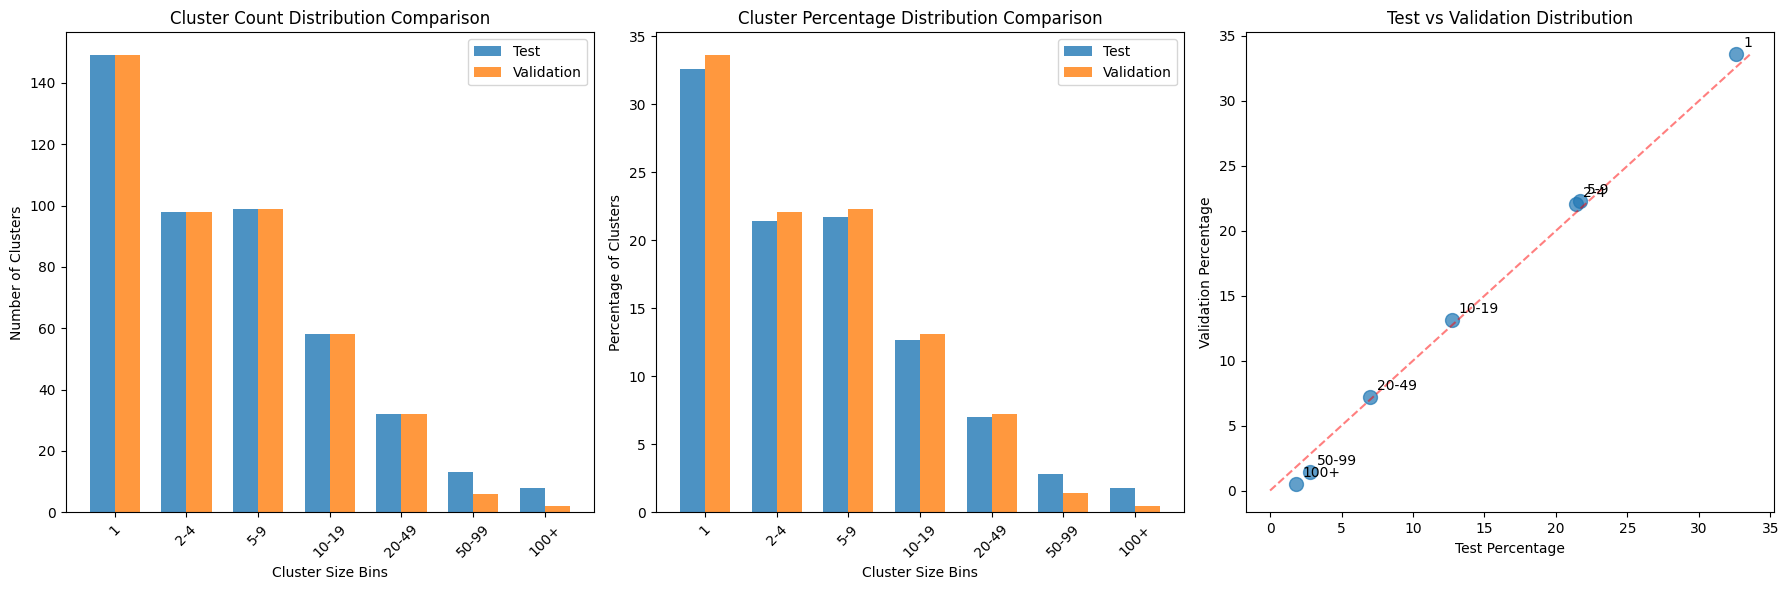


Distribution similarity analysis:
----------------------------------------
Kolmogorov-Smirnov test:
  Statistic: 0.0432
  p-value: 0.7698
  Distributions are similar (α=0.05)
Mean Absolute Percentage Error: 19.62%


In [15]:
# Visualize the distribution matching
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Test distribution
test_counts = [test_distribution.get(bin_label, 0) for bin_label in bin_labels]
validation_counts = [validation_distribution.get(bin_label, 0) for bin_label in bin_labels]

# Bar plot comparison
x = np.arange(len(bin_labels))
width = 0.35

axes[0].bar(x - width/2, test_counts, width, label='Test', alpha=0.8)
axes[0].bar(x + width/2, validation_counts, width, label='Validation', alpha=0.8)
axes[0].set_xlabel('Cluster Size Bins')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Cluster Count Distribution Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(bin_labels, rotation=45)
axes[0].legend()

# Percentage comparison
test_pcts = [test_distribution_pct.get(bin_label, 0) for bin_label in bin_labels]
val_pcts = [validation_distribution_pct.get(bin_label, 0) for bin_label in bin_labels]

axes[1].bar(x - width/2, test_pcts, width, label='Test', alpha=0.8)
axes[1].bar(x + width/2, val_pcts, width, label='Validation', alpha=0.8)
axes[1].set_xlabel('Cluster Size Bins')
axes[1].set_ylabel('Percentage of Clusters')
axes[1].set_title('Cluster Percentage Distribution Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(bin_labels, rotation=45)
axes[1].legend()

# Scatter plot: test vs validation percentages
axes[2].scatter(test_pcts, val_pcts, s=100, alpha=0.7)
axes[2].plot([0, max(max(test_pcts), max(val_pcts))], [0, max(max(test_pcts), max(val_pcts))], 'r--', alpha=0.5)
axes[2].set_xlabel('Test Percentage')
axes[2].set_ylabel('Validation Percentage')
axes[2].set_title('Test vs Validation Distribution')
for i, bin_label in enumerate(bin_labels):
    axes[2].annotate(bin_label, (test_pcts[i], val_pcts[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Calculate distribution similarity metrics
from scipy.stats import ks_2samp

# Reconstruct the actual cluster sizes for statistical comparison
test_cluster_sizes_expanded = []
for cluster_info in test_cluster_info.itertuples():
    test_cluster_sizes_expanded.append(cluster_info.size)

validation_cluster_sizes_expanded = []
for cluster_info in validation_clusters_info.itertuples():
    validation_cluster_sizes_expanded.append(cluster_info.cluster_size)

# Statistical tests
ks_stat, ks_p = ks_2samp(test_cluster_sizes_expanded, validation_cluster_sizes_expanded)

print(f"\nDistribution similarity analysis:")
print("-" * 40)
print(f"Kolmogorov-Smirnov test:")
print(f"  Statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_p:.4f}")
print(f"  Distributions {'are similar' if ks_p > 0.05 else 'are significantly different'} (α=0.05)")

# Calculate mean absolute percentage error between distributions
mape = np.mean(np.abs((np.array(test_pcts) - np.array(val_pcts)) / (np.array(test_pcts) + 1e-8))) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


In [16]:
# Save validation sequence list
print(f"\nSaving validation sequence list...")
print("-" * 40)

# Create detailed validation info
validation_detailed = []
for seq_id in validation_sequences:
    split, pdb_id, chain = seq_id.split('_')
    cluster_id = clusters[clusters['seq_id'] == seq_id]['cluster_id'].iloc[0]
    cluster_size = clusters[clusters['cluster_id'] == cluster_id].shape[0]
    
    validation_detailed.append({
        'seq_id': seq_id,
        'pdb_id': pdb_id,
        'chain': chain,
        'cluster_id': cluster_id,
        'cluster_size': cluster_size
    })

validation_detailed_df = pd.DataFrame(validation_detailed)

# Save to file
validation_detailed_df.to_csv('../../pipeline/output/validation_sequences.csv', index=False)
print(f"Saved {len(validation_detailed_df)} validation sequences to validation_sequences.csv")

# Also save just the sequence IDs
with open('../../pipeline/output/validation_seq_ids.txt', 'w') as f:
    for seq_id in validation_sequences:
        f.write(f"{seq_id}\n")
print(f"Saved sequence IDs to validation_seq_ids.txt")

# Show summary
print(f"\nValidation set summary:")
print(f"Total sequences: {len(validation_sequences)}")
print(f"Unique PDBs: {len(validation_pdbs)}")
print(f"Clusters: {len(validation_cluster_ids)}")

# Show examples
print(f"\nSample validation sequences:")
sample_val = validation_detailed_df.head(10)
for _, row in sample_val.iterrows():
    print(f"  {row['seq_id']} (cluster: {row['cluster_id']}, size: {row['cluster_size']})")

# Final verification: ensure no overlap with test sequences
test_sequences_set = set(clusters[clusters['split'] == 'test']['seq_id'])
validation_sequences_set = set(validation_sequences)
overlap = test_sequences_set.intersection(validation_sequences_set)

print(f"\nValidation quality check:")
print(f"Overlap with test sequences: {len(overlap)} (should be 0)")
if len(overlap) > 0:
    print("WARNING: Found overlap sequences!")
    for seq in list(overlap)[:5]:
        print(f"  {seq}")
else:
    print("✓ No overlap with test sequences - validation set is clean!")

# Check overlap of PDBs
test_pdbs_set = set(clusters[clusters['split'] == 'test']['pdb_id'])
validation_pdbs_set = set(validation_pdbs)
pdb_overlap = test_pdbs_set.intersection(validation_pdbs_set)

print(f"Overlap with test PDBs: {len(pdb_overlap)} (should be 0)")
if len(pdb_overlap) > 0:
    print("WARNING: Found PDB overlap!")
    for pdb in list(pdb_overlap)[:5]:
        print(f"  {pdb}")
else:
    print("✓ No PDB overlap with test set - validation set is structurally independent!")



Saving validation sequence list...
----------------------------------------
Saved 951 validation sequences to validation_sequences.csv
Saved sequence IDs to validation_seq_ids.txt

Validation set summary:
Total sequences: 951
Unique PDBs: 444
Clusters: 444

Sample validation sequences:
  train_3QFK_A (cluster: train_3QFK_A, size: 1)
  train_3MN2_B (cluster: train_3MN2_B, size: 2)
  train_3MN2_A (cluster: train_3MN2_B, size: 2)
  train_3D3Y_A (cluster: train_3D3Y_A, size: 1)
  train_3GO5_A (cluster: train_3GO5_A, size: 1)
  train_2WVP_A (cluster: train_2WVP_A, size: 1)
  train_8ITQ_A (cluster: train_8ITQ_A, size: 1)
  train_6E1C_B (cluster: train_6E1C_B, size: 2)
  train_6E1C_A (cluster: train_6E1C_B, size: 2)
  train_1MIX_A (cluster: train_1MIX_A, size: 1)

Validation quality check:
Overlap with test sequences: 0 (should be 0)
✓ No overlap with test sequences - validation set is clean!
Overlap with test PDBs: 0 (should be 0)
✓ No PDB overlap with test set - validation set is structura

In [17]:
clusters

,cluster_id,seq_id,split,pdb_id,chain,cluster_split,cluster_pdb,cluster_chain
0,train_5ZZK_A,train_5ZZK_A,train,5ZZK,A,train,5ZZK,A
1,train_6BZQ_C,train_6BZQ_C,train,6BZQ,C,train,6BZQ,C
2,train_6BZQ_C,train_6BZQ_D,train,6BZQ,D,train,6BZQ,C
3,train_6BZQ_C,train_6BZA_A,train,6BZA,A,train,6BZQ,C
4,train_6BZQ_C,train_6BZA_B,train,6BZA,B,train,6BZQ,C
...,...,...,...,...,...,...,...,...
25874,train_8P14_A,train_8P19_A,train,8P19,A,train,8P14,A
25875,train_8P14_A,train_6HEH_A,train,6HEH,A,train,8P14,A
25876,train_2E4T_A,train_2E4T_A,train,2E4T,A,train,2E4T,A
25877,train_4QQ0_A,train_4QQ0_A,train,4QQ0,A,train,4QQ0,A


Comparing with training sequence max identities...
Analyzing 794 training sequences for comparison...
Successfully analyzed 580 training sequences

Comparison of Max Identities:
----------------------------------------
Test sequences:
  Mean: 0.820 ± 0.220
  Median: 0.939
  Range: 0.304 - 1.000

Training sequences (sample):
  Mean: 0.884 ± 0.176
  Median: 0.958
  Range: 0.314 - 1.000


/tmp/ipykernel_5298/2233901042.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1].boxplot(data_to_plot, labels=['Test', 'Train'])


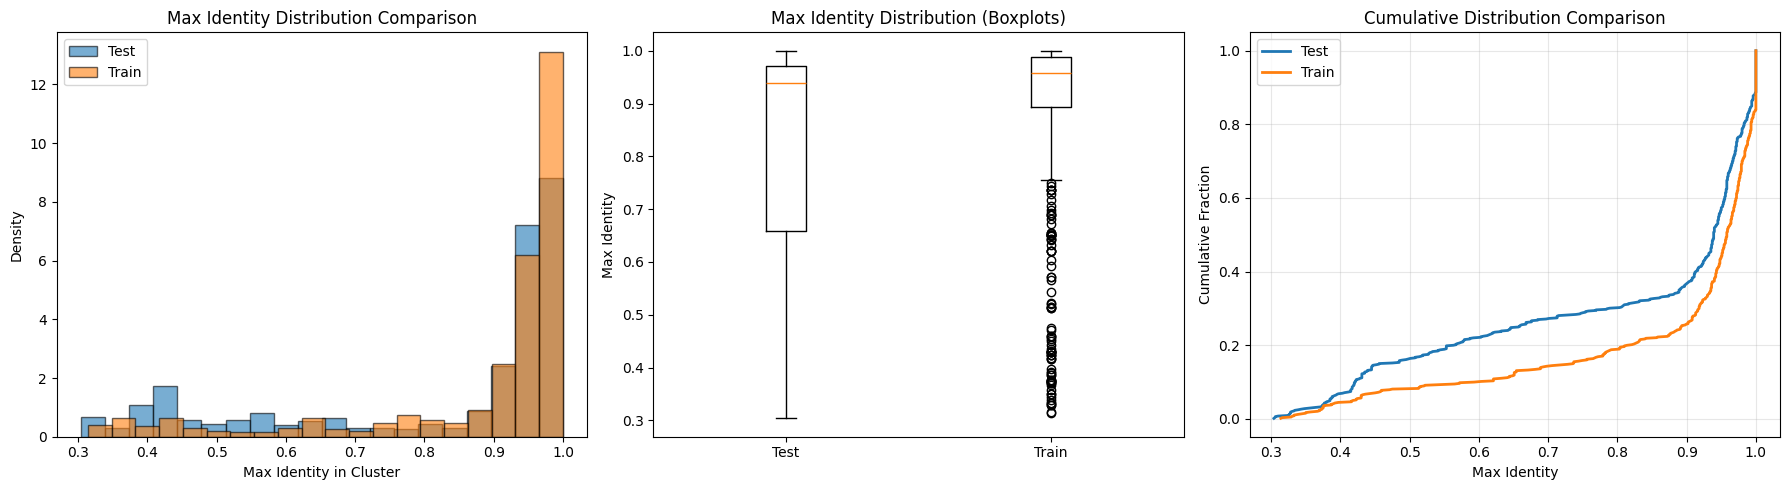


Identity Distribution Comparison:
----------------------------------------
High identity (≥90%):
  Test: 63.4%
  Train: 74.3%
Medium identity (50-90%):
  Test: 20.3%
  Train: 17.6%
Low identity (<50%):
  Test: 16.3%
  Train: 8.1%


In [18]:
# Additional analysis: Compare with training sequences
print("Comparing with training sequence max identities...")
print("=" * 60)

# Get a sample of training PDBs for comparison
train_pdbs = clusters[clusters['split'] == 'train']['pdb_id'].unique()
test_pdbs = clusters[clusters['split'] == 'test']['pdb_id'].unique()
train_sample_size = min(len(test_pdbs), len(train_pdbs))
train_sample = np.random.choice(train_pdbs, train_sample_size, replace=False)
train_sample = clusters[clusters['pdb_id'].isin(train_sample)]['seq_id'].unique()

print(f"Analyzing {len(train_sample)} training sequences for comparison...")

# Calculate max identities for training sample
train_max_identities = []
train_analysis_results = []

for train_seq in train_sample:
    max_id, max_target, num_comparisons = calculate_max_identity_in_cluster(train_seq, clusters, similarity)
    
    if max_id is not None:
        train_max_identities.append(max_id)
        train_analysis_results.append({
            'seq': train_seq,
            'max_identity': max_id,
            'max_target': max_target,
            'num_comparisons': num_comparisons
        })

print(f"Successfully analyzed {len(train_max_identities)} training sequences")

if len(train_max_identities) > 0 and len(max_identities) > 0:
    # Compare statistics
    print(f"\nComparison of Max Identities:")
    print("-" * 40)
    print(f"Test sequences:")
    print(f"  Mean: {np.mean(max_identities):.3f} ± {np.std(max_identities):.3f}")
    print(f"  Median: {np.median(max_identities):.3f}")
    print(f"  Range: {min(max_identities):.3f} - {max(max_identities):.3f}")
    
    print(f"\nTraining sequences (sample):")
    print(f"  Mean: {np.mean(train_max_identities):.3f} ± {np.std(train_max_identities):.3f}")
    print(f"  Median: {np.median(train_max_identities):.3f}")
    print(f"  Range: {min(train_max_identities):.3f} - {max(train_max_identities):.3f}")
    
    # Visualization comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Overlapped histograms
    axes[0].hist(max_identities, bins=20, alpha=0.6, label='Test', density=True, edgecolor='black')
    axes[0].hist(train_max_identities, bins=20, alpha=0.6, label='Train', density=True, edgecolor='black')
    axes[0].set_xlabel('Max Identity in Cluster')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Max Identity Distribution Comparison')
    axes[0].legend()
    
    # Box plots
    data_to_plot = [max_identities, train_max_identities]
    box_plot = axes[1].boxplot(data_to_plot, labels=['Test', 'Train'])
    axes[1].set_ylabel('Max Identity')
    axes[1].set_title('Max Identity Distribution (Boxplots)')
    
    # Cumulative distributions
    test_sorted = sorted(max_identities)
    test_cumulative = np.arange(1, len(test_sorted) + 1) / len(test_sorted)
    train_sorted = sorted(train_max_identities)
    train_cumulative = np.arange(1, len(train_sorted) + 1) / len(train_sorted)
    
    axes[2].plot(test_sorted, test_cumulative, label='Test', linewidth=2)
    axes[2].plot(train_sorted, train_cumulative, label='Train', linewidth=2)
    axes[2].set_xlabel('Max Identity')
    axes[2].set_ylabel('Cumulative Fraction')
    axes[2].set_title('Cumulative Distribution Comparison')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identity thresholds comparison
    test_high = len([x for x in max_identities if x >= 0.9]) / len(max_identities) * 100
    test_medium = len([x for x in max_identities if 0.5 <= x < 0.9]) / len(max_identities) * 100
    test_low = len([x for x in max_identities if x < 0.5]) / len(max_identities) * 100
    
    train_high = len([x for x in train_max_identities if x >= 0.9]) / len(train_max_identities) * 100
    train_medium = len([x for x in train_max_identities if 0.5 <= x < 0.9]) / len(train_max_identities) * 100
    train_low = len([x for x in train_max_identities if x < 0.5]) / len(train_max_identities) * 100
    
    print(f"\nIdentity Distribution Comparison:")
    print("-" * 40)
    print(f"High identity (≥90%):")
    print(f"  Test: {test_high:.1f}%")
    print(f"  Train: {train_high:.1f}%")
    
    print(f"Medium identity (50-90%):")
    print(f"  Test: {test_medium:.1f}%")
    print(f"  Train: {train_medium:.1f}%")
    
    print(f"Low identity (<50%):")
    print(f"  Test: {test_low:.1f}%")
    print(f"  Train: {train_low:.1f}%")


In [19]:
# select 500 pdb from train, but not is same clusters as test
test_clusters = clusters[clusters['split'] == 'test']['cluster_id'].unique()
pdb_with_test = clusters[clusters['cluster_id'].isin(test_clusters)]['pdb_id'].unique()
test_pdb = seq_test['pdb_id'].unique()



In [20]:
# val_pdb = np.random.choice(pdb_not_with_test, size=500, replace=False)
# val_pdb = np.random.choice(seq_train['pdb_id'], size=500, replace=False)
val_pdb = clusters.sample(frac=1, replace=False).drop_duplicates(['cluster_id', 'pdb_id']).pdb_id[:500].unique()
len(val_pdb)

500

In [21]:
clusters.sample(frac=1, replace=False).drop_duplicates(['cluster_id', 'pdb_id'])

,cluster_id,seq_id,split,pdb_id,chain,cluster_split,cluster_pdb,cluster_chain
2165,train_5OH8_A,train_4V31_B,train,4V31,B,train,5OH8,A
18678,train_2R0J_A,train_3RZ3_D,train,3RZ3,D,train,2R0J,A
16378,train_1HQZ_1,train_1HQZ_6,train,1HQZ,6,train,1HQZ,1
23953,train_1RF6_A,train_1RF5_C,train,1RF5,C,train,1RF6,A
21523,train_7FSU_C,train_7FSU_B,train,7FSU,B,train,7FSU,C
...,...,...,...,...,...,...,...,...
11692,test_4P0D_A,test_4P0D_A,test,4P0D,A,test,4P0D,A
7916,train_4H8Q_A,train_4H8Q_A,train,4H8Q,A,train,4H8Q,A
251,train_2OW3_B,train_4EHV_A,train,4EHV,A,train,2OW3,B
16504,train_4X2F_A,train_5E91_A,train,5E91,A,train,4X2F,A


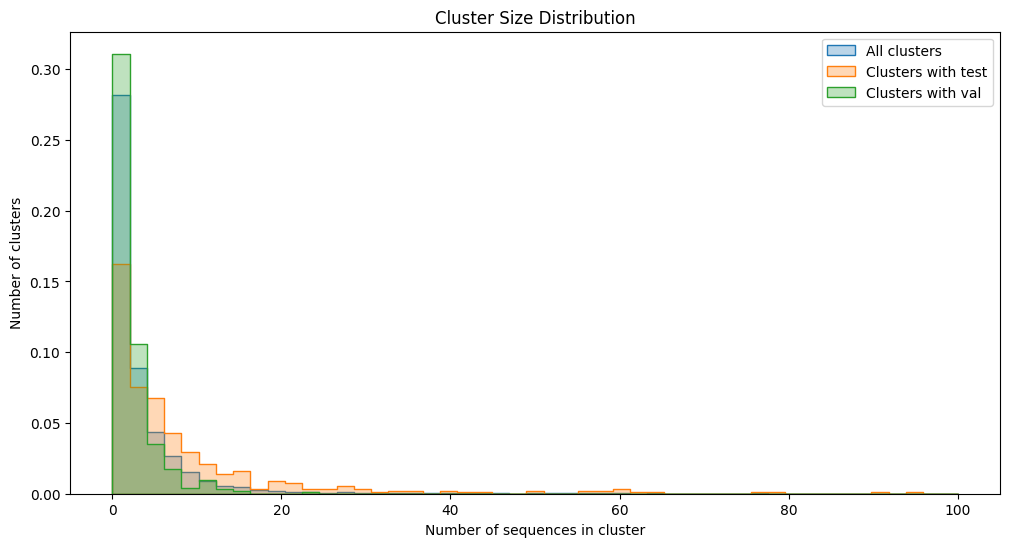

Total clusters: 6141
Clusters with test sequences: 457
Percentage of clusters with test: 7.44%


In [22]:
bins=np.linspace(0, 100, 50 )
clusters[['split', 'pdb_id', 'chain']] = clusters['seq_id'].str.split('_', expand=True)
clusters[['cluster_split', 'cluster_pdb', 'cluster_chain']] = clusters['cluster_id'].str.split('_', expand=True)

cluster_sizes = clusters['cluster_id'].value_counts().reset_index()
cluster_sizes.columns = ['cluster_id', 'size']

clusters_with_test = clusters[clusters['split'] == 'test']['cluster_id'].unique()
test_clusters_df = clusters[clusters['cluster_id'].isin(clusters_with_test)]
test_cluster_sizes = test_clusters_df['cluster_id'].value_counts().reset_index()
test_cluster_sizes.columns = ['cluster_id', 'size']

val_clusters_df = clusters[clusters['pdb_id'].isin(val_pdb)]
val_cluster_sizes = val_clusters_df['cluster_id'].value_counts().reset_index()
val_cluster_sizes.columns = ['cluster_id', 'size']

clusters_without_test = clusters[~clusters['cluster_id'].isin(clusters_with_test)]
clusters_without_test_sizes = clusters_without_test['cluster_id'].value_counts().reset_index()
clusters_without_test_sizes.columns = ['cluster_id', 'size']

plt.figure(figsize=(12, 6))
sns.histplot(data=cluster_sizes, x='size', bins=bins, alpha=0.3, label='All clusters', stat='density', element="step")
# sns.histplot(data=clusters_without_test_sizes, x='size', bins=bins, alpha=0.3, label='Clusters without test', stat='density', element="step")
sns.histplot(data=test_cluster_sizes, x='size', bins=bins, alpha=0.3, label='Clusters with test', stat='density', element="step")
sns.histplot(data=val_cluster_sizes, x='size', bins=bins, alpha=0.3, label='Clusters with val', stat='density', element="step")
plt.title('Cluster Size Distribution')
plt.xlabel('Number of sequences in cluster')
plt.ylabel('Number of clusters')
# plt.yscale('log')
plt.legend()
plt.show()

print(f"Total clusters: {len(cluster_sizes)}")
print(f"Clusters with test sequences: {len(test_cluster_sizes)}")
print(f"Percentage of clusters with test: {len(test_cluster_sizes)/len(cluster_sizes)*100:.2f}%")


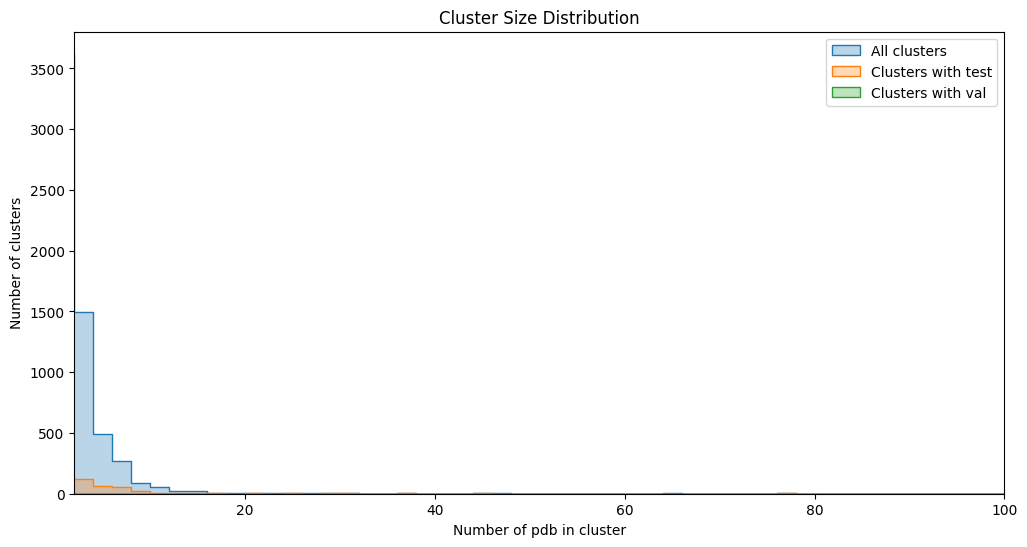

/tmp/ipykernel_5298/1199270923.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


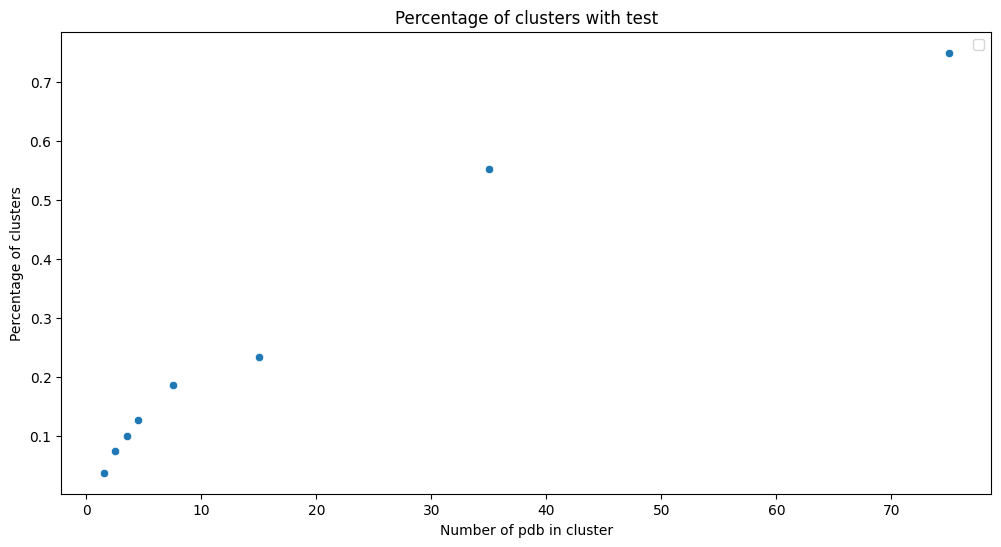

Total clusters: 6141
Clusters with test sequences: 457
Percentage of clusters with test: 7.44%


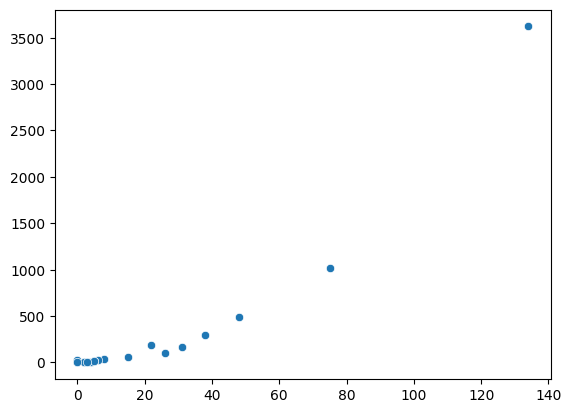

In [24]:
bins=np.linspace(0, 100, 51 )
clusters[['split', 'pdb_id', 'chain']] = clusters['seq_id'].str.split('_', expand=True)
clusters[['cluster_split', 'cluster_pdb', 'cluster_chain']] = clusters['cluster_id'].str.split('_', expand=True)

cluster_sizes = clusters.drop_duplicates(['cluster_id', 'pdb_id'])['cluster_id'].value_counts().reset_index()
cluster_sizes.columns = ['cluster_id', 'size']

clusters_with_test = clusters[clusters['split'] == 'test']['cluster_id'].unique()
test_clusters_df = clusters[clusters['cluster_id'].isin(clusters_with_test)]
test_cluster_sizes = test_clusters_df.drop_duplicates(['cluster_id', 'pdb_id'])['cluster_id'].value_counts().reset_index()
test_cluster_sizes.columns = ['cluster_id', 'size']

val_clusters_df = clusters[clusters['pdb_id'].isin(val_pdb)]
val_cluster_sizes = val_clusters_df.drop_duplicates(['cluster_id', 'pdb_id'])['cluster_id'].value_counts().reset_index()
val_cluster_sizes.columns = ['cluster_id', 'size']

clusters_without_test = clusters[~clusters['cluster_id'].isin(clusters_with_test)]
clusters_without_test_sizes = clusters_without_test.drop_duplicates(['cluster_id', 'pdb_id'])['cluster_id'].value_counts().reset_index()
clusters_without_test_sizes.columns = ['cluster_id', 'size']

plt.figure(figsize=(12, 6))
sns.histplot(data=cluster_sizes, x='size', bins=bins, alpha=0.3, label='All clusters', stat='count', element="step")
# sns.histplot(data=clusters_without_test_sizes, x='size', bins=bins, alpha=0.3, label='Clusters without test', stat='density', element="step")
sns.histplot(data=test_cluster_sizes, x='size', bins=bins, alpha=0.3, label='Clusters with test', stat='count', element="step")
sns.histplot(data=val_cluster_sizes, x='size', bins=bins, alpha=0.3, label='Clusters with val', stat='density', element="step")
plt.title('Cluster Size Distribution')
plt.xlabel('Number of pdb in cluster')
plt.ylabel('Number of clusters')
plt.xlim(2,100)
# plt.yscale('log')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
# percentage of clusters with test
cluster_size_bins = np.array([1, 2,3,4, 5, 10, 20, 50, 100])
bins = np.linspace(0, 20, 21)
sns.scatterplot(x=(cluster_size_bins[1:]+cluster_size_bins[:-1])/2, y=np.histogram(test_cluster_sizes['size'], cluster_size_bins)[0] / np.histogram(cluster_sizes['size'], cluster_size_bins)[0])
plt.title('Percentage of clusters with test')
plt.xlabel('Number of pdb in cluster')
plt.ylabel('Percentage of clusters')
plt.legend()
plt.show()
sns.scatterplot(x=np.histogram(test_cluster_sizes['size'], bins)[0], y=np.histogram(cluster_sizes['size'], bins)[0])


print(f"Total clusters: {len(cluster_sizes)}")
print(f"Clusters with test sequences: {len(test_cluster_sizes)}",)
print(f"Percentage of clusters with test: {len(test_cluster_sizes)/len(cluster_sizes)*100:.2f}%")


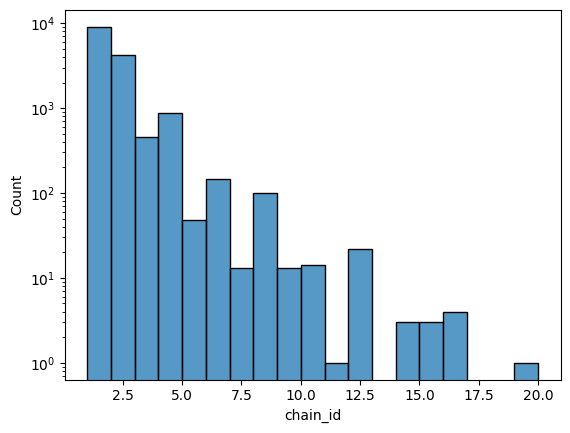

In [26]:
sns.histplot(seq_train.groupby('pdb_id')['chain_id'].size(), bins=np.linspace(1, 20, 20))
plt.yscale('log')
plt.show()

In [27]:
seq_train.groupby('pdb_id')['chain_id'].size().value_counts()

chain_id
1     9072
2     4179
4      869
3      462
6      145
8       99
5       48
12      22
10      14
9       13
7       13
16       4
15       3
14       3
20       1
11       1
24       1
Name: count, dtype: int64

In [29]:
similarity['query_pdb'] = similarity['query_id'].str.split('_').str[1]
similarity['target_pdb'] = similarity['target_id'].str.split('_').str[1]

similarity['query_chain'] = similarity['query_id'].str.split('_').str[2]
similarity['target_chain'] = similarity['target_id'].str.split('_').str[2]

In [30]:
similarity_into_one = similarity[similarity['query_pdb'] == similarity['target_pdb']]
similarity_into_one = similarity_into_one[similarity_into_one['query_id'] != similarity_into_one['target_id']]
similarity_into_one = similarity_into_one.drop_duplicates(['query_id', 'target_id'])
similarity_into_one = similarity_into_one.set_index(['query_id', 'target_id']).sort_index()
similarity_into_one.head()

score  identity         evalue  q_start  q_end  \
query_id    target_id                                                     
test_1BB3_A test_1BB3_B    287     1.000   1.926000e-90        0    129   
test_1BB3_B test_1BB3_A    287     1.000   1.926000e-90        0    129   
test_1DX9_A test_1DX9_B    348     0.977  9.297000e-111        0    167   
            test_1DX9_C    348     0.977  9.297000e-111        0    167   
            test_1DX9_D    348     0.977  9.297000e-111        0    167   

                         q_len  t_start  t_end  t_len query_pdb target_pdb  \
query_id    target_id                                                        
test_1BB3_A test_1BB3_B    130        0    129    130      1BB3       1BB3   
test_1BB3_B test_1BB3_A    130        0    129    130      1BB3       1BB3   
test_1DX9_A test_1DX9_B    168        0    167    168      1DX9       1DX9   
            test_1DX9_C    168        0    167    168      1DX9       1DX9   
            test_1DX9_D    168        0    167    168      1DX9       1DX9   

                        query_chain target_chain  
query_id    target_id                             
test_1BB3_A test_1BB3_B           A            B  
test_1BB3_B test_1BB3_A           B            A  
test_1DX9_A test_1DX9_B           A            B  
            test_1DX9_C           A            C  
            test_1DX9_D           A            D

In [31]:
pairs = []
for df in seq_train ,seq_test:
    for val,group in df[['id', 'pdb_id']].groupby('pdb_id'):
        sequences = group['id']
        for seq in sequences:
            for seq2 in sequences:
                if seq != seq2:
                    pairs.append([seq, seq2])

mult = pd.MultiIndex.from_tuples(pairs, names=['query_id', 'target_id'])

In [32]:
similarity_into_one = similarity_into_one.reindex(mult).fillna(0)

<Axes: xlabel='id', ylabel='Count'>

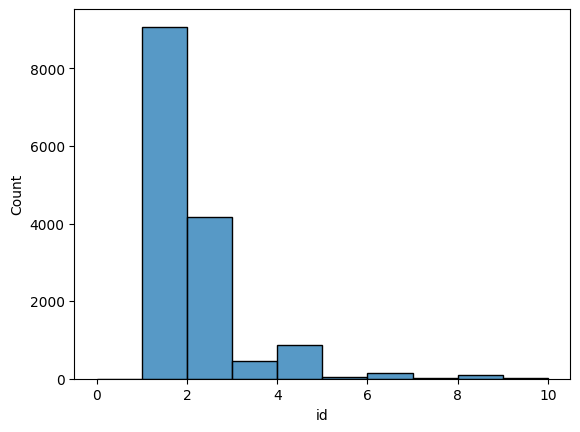

In [33]:
sns.histplot(seq_train.groupby('pdb_id')['id'].nunique(),bins=np.linspace(0,10,11))

Pdb with  2  chains:  4305
8610
4305.0


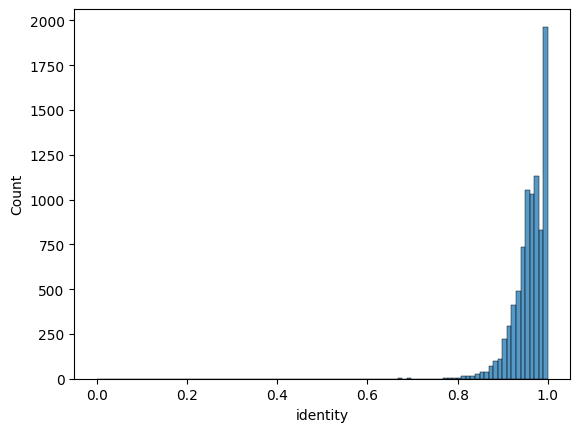

Pdb with  3  chains:  469
2814
469.0


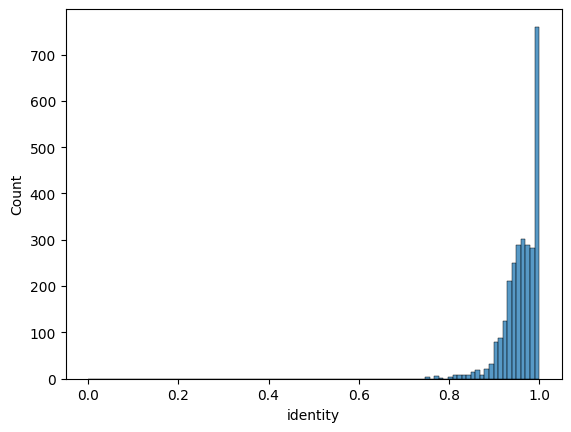

Pdb with  4  chains:  906
10872
906.0


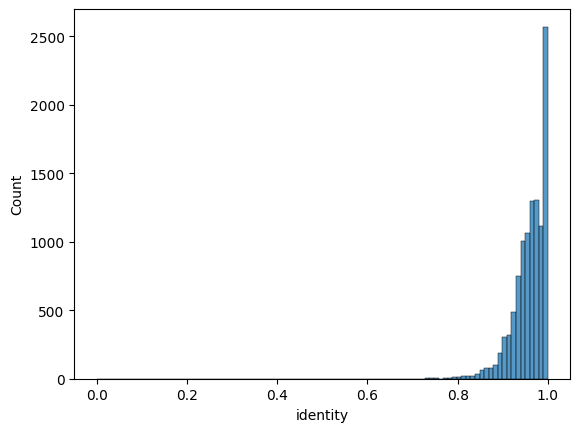

Pdb with  5  chains:  50
1000
50.0


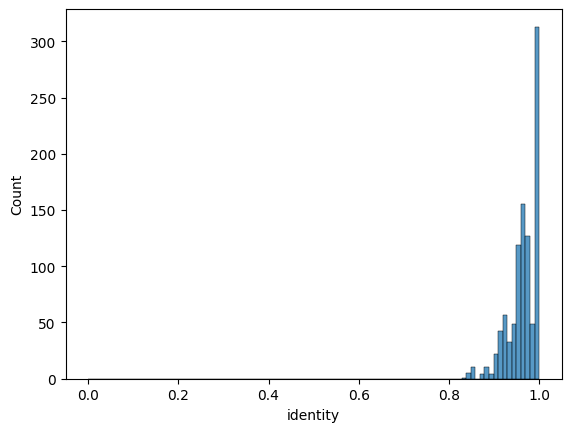

Pdb with  6  chains:  151
4530
151.0


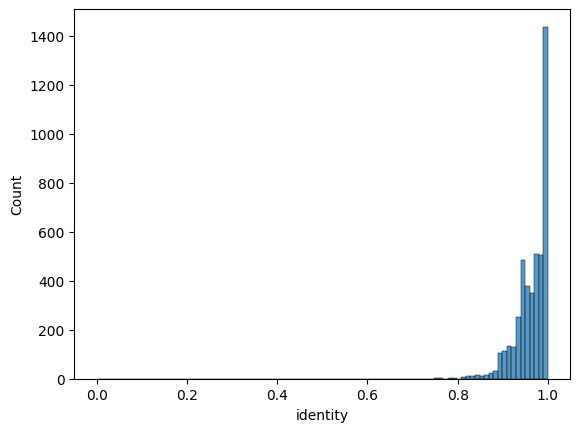

Pdb with  7  chains:  13
546
13.0


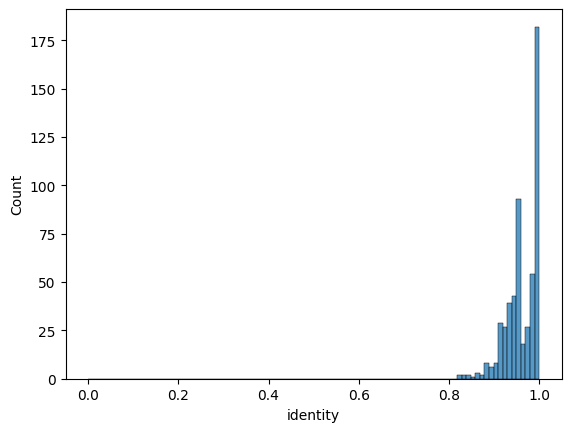

Pdb with  8  chains:  101
5656
101.0


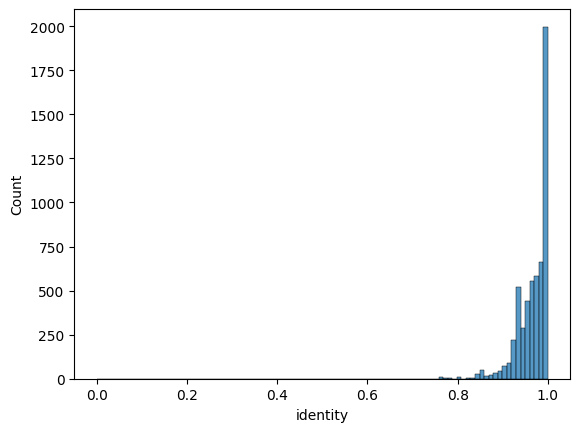

Pdb with  9  chains:  13
936
13.0


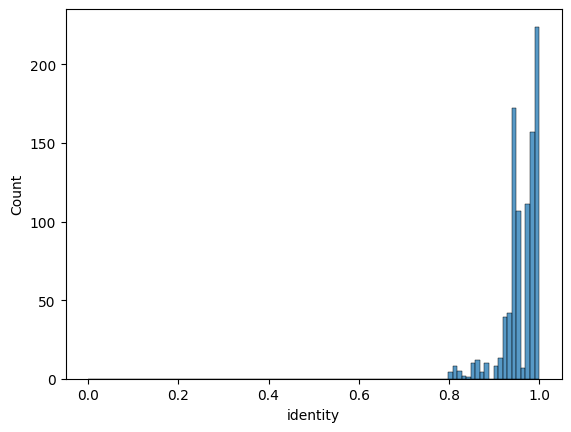

In [35]:
for i in range(2,10):
    n_pairs = i*(i-1)
    pdb_ids = similarity_into_one['target_pdb'].value_counts()
    pdb_ids = pdb_ids[pdb_ids == n_pairs].index
    print('Pdb with ', i, ' chains: ', len(pdb_ids))
    sims = similarity_into_one[similarity_into_one['target_pdb'].isin(pdb_ids)]
    print(sims.shape[0])
    print(sims.shape[0]/n_pairs)
    sns.histplot(sims['identity'], bins=np.linspace(0, 1, 100))
    plt.show()

In [52]:
# Validation dataset creation based on test cluster PDB distribution
print("Creating validation dataset based on test cluster PDB distribution")
print("=" * 80)

# Step 1: Analyze PDB count distribution in test clusters
print("1. Analyzing PDB count distribution in test clusters...")

# Find clusters that contain test samples
test_cluster_ids = clusters[clusters['split'] == 'test']['cluster_id'].unique()

# Count total PDBs in these clusters (both train and test)
test_cluster_pdb_counts = clusters[clusters['cluster_id'].isin(test_cluster_ids)].groupby('cluster_id')['pdb_id'].nunique().reset_index()
test_cluster_pdb_counts.columns = ['cluster_id', 'pdb_count']

print(f"PDB count distribution in test clusters:")
print(test_cluster_pdb_counts['pdb_count'].value_counts().sort_index())

# Define bins: 1, 2, 3, 4, 5, 10, 20, 40, inf
pdb_bins = [0, 1, 2, 3, 4, 6, 10, 20, 40, float('inf')]
bin_labels = ['1', '2', '3', '4', '4-6', '7-10', '11-20', '21-40', '40+']

test_cluster_pdb_counts['pdb_bin'] = pd.cut(test_cluster_pdb_counts['pdb_count'], 
                                          bins=pdb_bins, 
                                          labels=bin_labels, 
                                          include_lowest=True)

test_bin_distribution = test_cluster_pdb_counts['pdb_bin'].value_counts().sort_index()
test_bin_distribution_pct = (test_bin_distribution / test_bin_distribution.sum() * 100).round(1)

print(f"\nTest cluster distribution by bins:")
for bin_label, count, pct in zip(test_bin_distribution.index, test_bin_distribution.values, test_bin_distribution_pct.values):
    print(f"  {bin_label}: {count} clusters ({pct}%)")


Creating validation dataset based on test cluster PDB distribution
1. Analyzing PDB count distribution in test clusters...
PDB count distribution in test clusters:
pdb_count
1      134
2       75
3       48
4       38
5       22
6       31
7       26
8       15
9        8
10       6
12       3
13       5
14       4
15       5
16       2
17       2
19       1
20       2
21       2
23       1
25       3
26       1
29       3
30       1
31       2
36       2
41       1
45       2
46       1
54       1
58       1
65       1
70       1
76       1
77       1
83       1
93       1
94       1
102      1
122      1
Name: count, dtype: int64

Test cluster distribution by bins:
  1: 134 clusters (29.3%)
  2: 75 clusters (16.4%)
  3: 48 clusters (10.5%)
  4: 38 clusters (8.3%)
  4-6: 53 clusters (11.6%)
  7-10: 55 clusters (12.0%)
  11-20: 24 clusters (5.3%)
  21-40: 15 clusters (3.3%)
  40+: 15 clusters (3.3%)


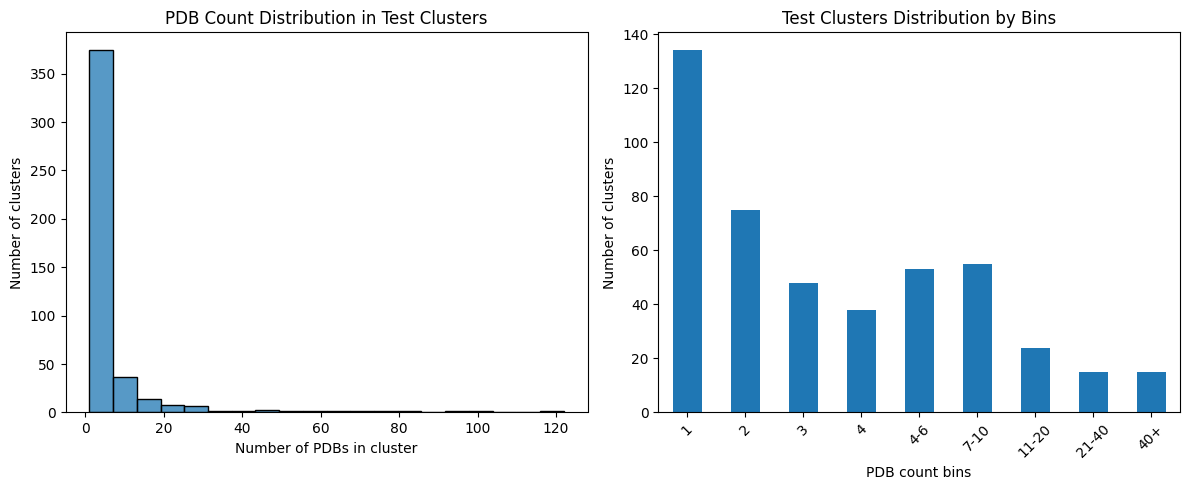

In [57]:
# Visualize test cluster PDB distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=test_cluster_pdb_counts, x='pdb_count', bins=20)
plt.title('PDB Count Distribution in Test Clusters')
plt.xlabel('Number of PDBs in cluster')
plt.ylabel('Number of clusters')
# plt.yscale('log')

plt.subplot(1, 2, 2)
test_bin_distribution.plot(kind='bar')
plt.title('Test Clusters Distribution by Bins')
plt.xlabel('PDB count bins')
plt.ylabel('Number of clusters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
# Step 2: Find available clusters (without test samples)
print("\n2. Finding available clusters for validation...")

test_cluster_ids = set(test_cluster_pdb_counts['cluster_id'])
all_cluster_ids = set(clusters['cluster_id'])
available_cluster_ids = all_cluster_ids - test_cluster_ids

print(f"Total clusters: {len(all_cluster_ids)}")
print(f"Clusters with test: {len(test_cluster_ids)}")
print(f"Available clusters: {len(available_cluster_ids)}")

# Count PDBs in available clusters
available_clusters = clusters[clusters['cluster_id'].isin(available_cluster_ids)]
available_cluster_pdb_counts = available_clusters.groupby('cluster_id')['pdb_id'].nunique().reset_index()
available_cluster_pdb_counts.columns = ['cluster_id', 'pdb_count']

available_cluster_pdb_counts['pdb_bin'] = pd.cut(available_cluster_pdb_counts['pdb_count'], 
                                               bins=pdb_bins, 
                                               labels=bin_labels, 
                                               include_lowest=True)

available_bin_distribution = available_cluster_pdb_counts['pdb_bin'].value_counts().sort_index()

print(f"\nAvailable clusters distribution by bins:")
for bin_label, count in zip(available_bin_distribution.index, available_bin_distribution.values):
    print(f"  {bin_label}: {count} clusters")



2. Finding available clusters for validation...
Total clusters: 6141
Clusters with test: 457
Available clusters: 5684

Available clusters distribution by bins:
  1: 3487 clusters
  2: 939 clusters
  3: 437 clusters
  4: 263 clusters
  4-6: 303 clusters
  7-10: 168 clusters
  11-20: 68 clusters
  21-40: 14 clusters
  40+: 5 clusters


In [59]:
# Step 3: Sample validation clusters according to test distribution
print("\n3. Sampling validation clusters according to test distribution...")

np.random.seed(42)  # For reproducibility
selected_validation_clusters = []
selected_validation_pdbs = set()

for bin_label in bin_labels:
    test_count = test_bin_distribution.get(bin_label, 0)
    available_count = available_bin_distribution.get(bin_label, 0)
    
    print(f"\nBin {bin_label}:")
    print(f"  Test clusters: {test_count}")
    print(f"  Available clusters: {available_count}")
    
    if test_count > 0 and available_count > 0:
        # Get clusters from this bin
        bin_clusters = available_cluster_pdb_counts[
            available_cluster_pdb_counts['pdb_bin'] == bin_label
        ]['cluster_id'].tolist()
        
        # Determine how many clusters to select
        target_count = min(test_count, available_count)
        
        # Sample clusters and PDBs from them
        selected_count = 0
        attempts = 0
        max_attempts = min(len(bin_clusters) * 3, 1000)  # Limit attempts
        
        while selected_count < target_count and attempts < max_attempts:
            attempts += 1
            
            # Select random cluster from this bin
            cluster_id = np.random.choice(bin_clusters)
            
            # Get all PDBs from this cluster (only train)
            cluster_pdbs = clusters[
                (clusters['cluster_id'] == cluster_id) & 
                (clusters['split'] == 'train')
            ]['pdb_id'].unique()
            
            if len(cluster_pdbs) == 0:
                continue
                
            # Select random PDB from cluster that hasn't been selected yet
            available_pdbs = [pdb for pdb in cluster_pdbs if pdb not in selected_validation_pdbs]
            
            if len(available_pdbs) > 0:
                selected_pdb = np.random.choice(available_pdbs)
                selected_validation_clusters.append(cluster_id)
                selected_validation_pdbs.add(selected_pdb)
                selected_count += 1
        
        print(f"  Selected: {selected_count} clusters")
    else:
        print(f"  Selected: 0 clusters")

print(f"\nTotal validation clusters selected: {len(selected_validation_clusters)}")
print(f"Total validation PDBs selected: {len(selected_validation_pdbs)}")



3. Sampling validation clusters according to test distribution...

Bin 1:
  Test clusters: 134
  Available clusters: 3487
  Selected: 134 clusters

Bin 2:
  Test clusters: 75
  Available clusters: 939
  Selected: 75 clusters

Bin 3:
  Test clusters: 48
  Available clusters: 437
  Selected: 48 clusters

Bin 4:
  Test clusters: 38
  Available clusters: 263
  Selected: 38 clusters

Bin 4-6:
  Test clusters: 53
  Available clusters: 303
  Selected: 53 clusters

Bin 7-10:
  Test clusters: 55
  Available clusters: 168
  Selected: 55 clusters

Bin 11-20:
  Test clusters: 24
  Available clusters: 68
  Selected: 24 clusters

Bin 21-40:
  Test clusters: 15
  Available clusters: 14
  Selected: 14 clusters

Bin 40+:
  Test clusters: 15
  Available clusters: 5
  Selected: 5 clusters

Total validation clusters selected: 446
Total validation PDBs selected: 446


In [60]:
# Step 4: Create final validation dataset
print("\n4. Creating final validation dataset...")

# Get all sequences for selected PDBs
validation_sequences = []
for pdb_id in selected_validation_pdbs:
    pdb_sequences = clusters[
        (clusters['pdb_id'] == pdb_id) & 
        (clusters['split'] == 'train')
    ]['seq_id'].tolist()
    validation_sequences.extend(pdb_sequences)

print(f"Total validation sequences: {len(validation_sequences)}")

# Check validation dataset quality
print("\n5. Validation dataset quality check...")

# Check overlaps with test
test_sequences_set = set(clusters[clusters['split'] == 'test']['seq_id'])
test_pdbs_set = set(clusters[clusters['split'] == 'test']['pdb_id'])
validation_sequences_set = set(validation_sequences)

seq_overlap = test_sequences_set.intersection(validation_sequences_set)
pdb_overlap = test_pdbs_set.intersection(selected_validation_pdbs)

print(f"Sequence overlap with test: {len(seq_overlap)} (should be 0)")
print(f"PDB overlap with test: {len(pdb_overlap)} (should be 0)")

if len(seq_overlap) == 0 and len(pdb_overlap) == 0:
    print(" Validation dataset is correct - no overlaps with test!")
else:
    print("Found overlaps with test dataset!")



4. Creating final validation dataset...
Total validation sequences: 767

5. Validation dataset quality check...
Sequence overlap with test: 0 (should be 0)
PDB overlap with test: 0 (should be 0)
 Validation dataset is correct - no overlaps with test!


In [61]:
# Step 6: Analyze final validation distribution
print("\n6. Analyzing final validation distribution...")

validation_cluster_pdb_counts = clusters[
    clusters['cluster_id'].isin(selected_validation_clusters)
].groupby('cluster_id')['pdb_id'].nunique().reset_index()
validation_cluster_pdb_counts.columns = ['cluster_id', 'pdb_count']

validation_cluster_pdb_counts['pdb_bin'] = pd.cut(validation_cluster_pdb_counts['pdb_count'], 
                                                bins=pdb_bins, 
                                                labels=bin_labels, 
                                                include_lowest=True)

validation_bin_distribution = validation_cluster_pdb_counts['pdb_bin'].value_counts().sort_index()
validation_bin_distribution_pct = (validation_bin_distribution / validation_bin_distribution.sum() * 100).round(1)

# Distribution comparison
print(f"\nDistribution comparison:")
print("-" * 60)
print(f"{'Bin':<8} {'Test %':<8} {'Val %':<8} {'Diff':<8}")
print("-" * 60)
for bin_label in bin_labels:
    test_pct = test_bin_distribution_pct.get(bin_label, 0)
    val_pct = validation_bin_distribution_pct.get(bin_label, 0)
    diff = abs(test_pct - val_pct)
    print(f"{bin_label:<8} {test_pct:<8.1f} {val_pct:<8.1f} {diff:<8.1f}")



6. Analyzing final validation distribution...

Distribution comparison:
------------------------------------------------------------
Bin      Test %   Val %    Diff    
------------------------------------------------------------
1        29.3     31.7     2.4     
2        16.4     16.8     0.4     
3        10.5     10.4     0.1     
4        8.3      8.7      0.4     
4-6      11.6     11.8     0.2     
7-10     12.0     12.1     0.1     
11-20    5.3      5.2      0.1     
21-40    3.3      2.6      0.7     
40+      3.3      0.7      2.6     


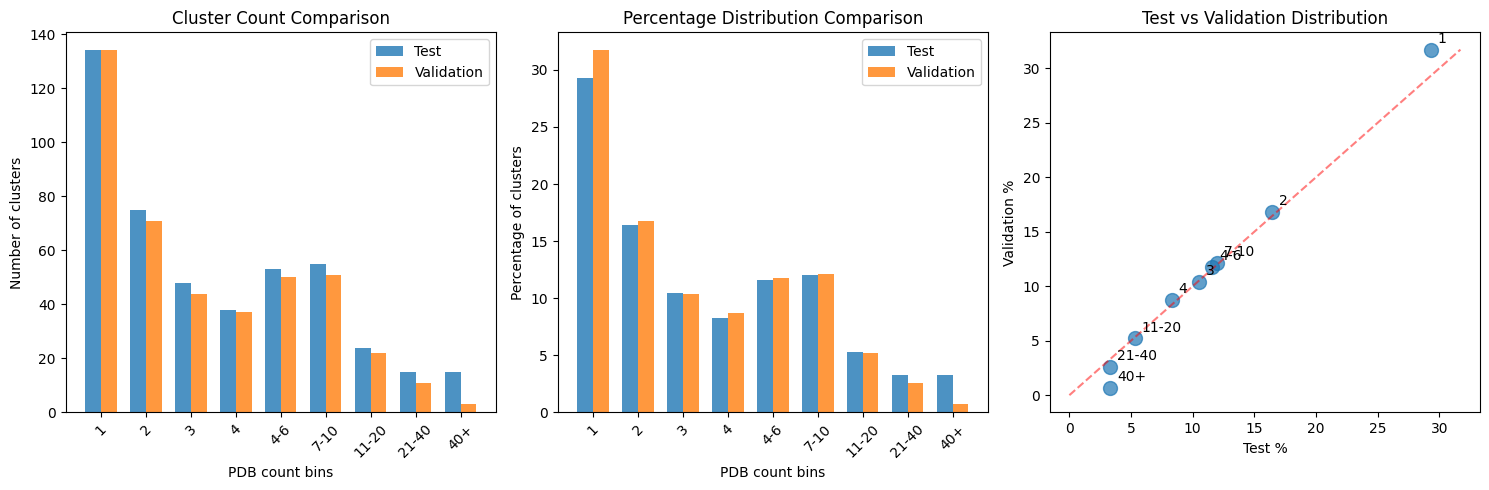

In [62]:
# Visualize distribution comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
x = np.arange(len(bin_labels))
width = 0.35
plt.bar(x - width/2, [test_bin_distribution.get(bin_label, 0) for bin_label in bin_labels], 
        width, label='Test', alpha=0.8)
plt.bar(x + width/2, [validation_bin_distribution.get(bin_label, 0) for bin_label in bin_labels], 
        width, label='Validation', alpha=0.8)
plt.xlabel('PDB count bins')
plt.ylabel('Number of clusters')
plt.title('Cluster Count Comparison')
plt.xticks(x, bin_labels, rotation=45)
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(x - width/2, [test_bin_distribution_pct.get(bin_label, 0) for bin_label in bin_labels], 
        width, label='Test', alpha=0.8)
plt.bar(x + width/2, [validation_bin_distribution_pct.get(bin_label, 0) for bin_label in bin_labels], 
        width, label='Validation', alpha=0.8)
plt.xlabel('PDB count bins')
plt.ylabel('Percentage of clusters')
plt.title('Percentage Distribution Comparison')
plt.xticks(x, bin_labels, rotation=45)
plt.legend()

plt.subplot(1, 3, 3)
test_pcts = [test_bin_distribution_pct.get(bin_label, 0) for bin_label in bin_labels]
val_pcts = [validation_bin_distribution_pct.get(bin_label, 0) for bin_label in bin_labels]
plt.scatter(test_pcts, val_pcts, s=100, alpha=0.7)
plt.plot([0, max(max(test_pcts), max(val_pcts))], [0, max(max(test_pcts), max(val_pcts))], 'r--', alpha=0.5)
plt.xlabel('Test %')
plt.ylabel('Validation %')
plt.title('Test vs Validation Distribution')
for i, bin_label in enumerate(bin_labels):
    plt.annotate(bin_label, (test_pcts[i], val_pcts[i]), xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


In [68]:
import json

with open('../../data/selected_validation_pdbs.json', 'w') as f:
    json.dump(list(map(str, selected_validation_pdbs)), f, sort_keys=True, indent=4)

with open('../../data/selected_validation_clusters.json', 'w') as f:
    json.dump(list(map(str, selected_validation_clusters)), f , sort_keys=True, indent=4)